In [ ]:
from Asylum_Research_AFM.Controls.master_panel import *
from Asylum_Research_AFM.Core.Igor_activex_grid import *
from Asylum_Research_AFM.Controls.scans import GridScan
import numpy as np

In [ ]:
gridscan = GridScan(numXgridpoints = 60, numYgridpoints = 60)


In [ ]:
# from m3_learning.util.file_IO import download_and_unzip


# # Download the data file from Zenodo
# url = 'https://zenodo.org/record/7774788/files/PZT_2080_raw_data.h5?download=1'



# # download the file
# download_and_unzip(filename, url, save_path)

## loads and example dataset

In [ ]:
from m3_learning.be.dataset import BE_Dataset

# Specify the filename and the path to save the file
filename = 'data_raw.h5'
save_path = './../../../Data/2023_rapid_fitting'
data_path = save_path + '/' + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path, resample_bins = 80)

# print the contents of the file
dataset.print_be_tree()

In this dataset

IO_rate_[Hz] : 4000000

BE_center_frequency_[Hz] : 1310000

BE_band_width_[Hz] : 200000

num_bins : 165

BE_repeats : 4

In [13]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

file = h5py.File(dataset.dataset, 'r')

# get the BE wave
BE_wave = file["/Measurement_000/Channel_000/Excitation_Waveform"][:]

num_bins = 200


In [14]:
spectroscopic_dims = file["/Measurement_000/Channel_000/Spectroscopic_Values"][:]

In [12]:
spectroscopic_dims.shape

(4, 63360)

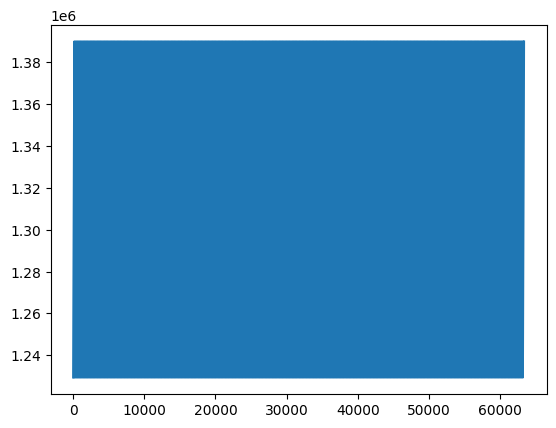

In [15]:
plt.plot(spectroscopic_dims[0])

In [16]:
print(spectroscopic_dims[1])

[ 0.         0.         0.        ... -0.6666667 -0.6666667 -0.6666667]


63360

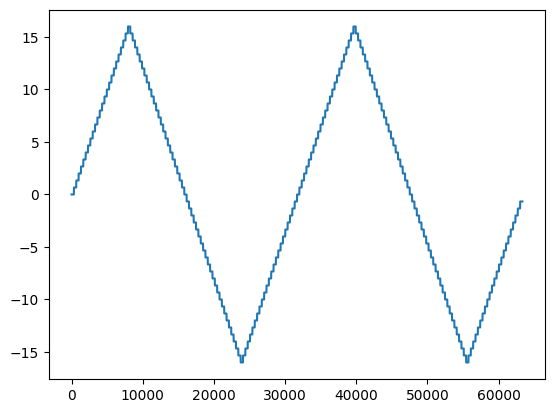

In [15]:
plt.plot(spectroscopic_dims[1])
len(spectroscopic_dims[1])

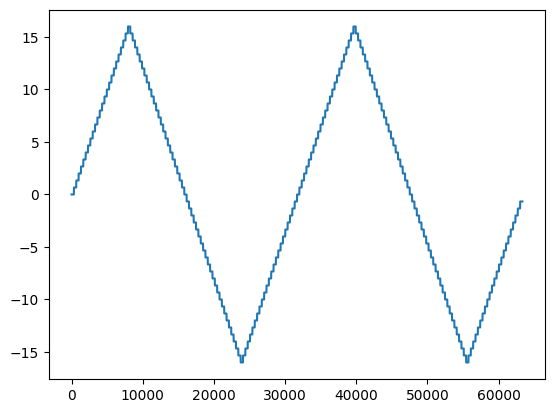

In [16]:
#plt.plot(spectroscopic_dims[1][7700:8500])
plt.plot(spectroscopic_dims[1])


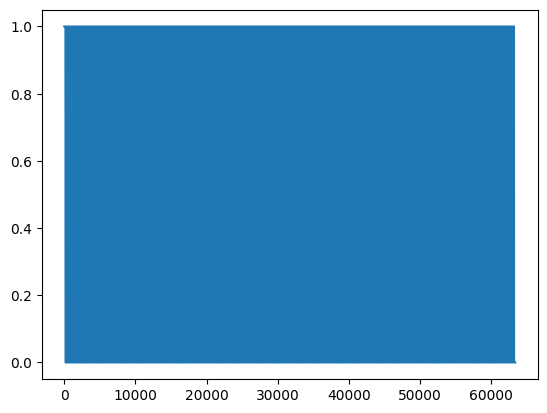

In [17]:
plt.plot(spectroscopic_dims[2])

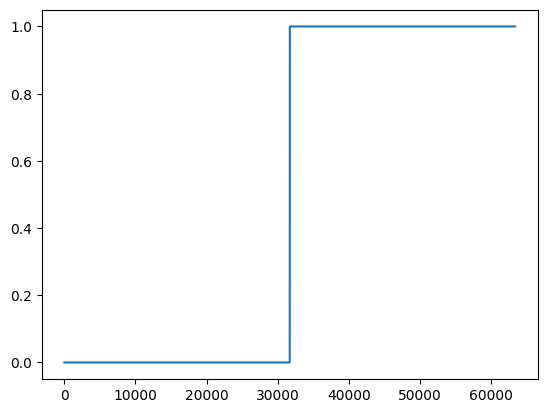

In [115]:
plt.plot(spectroscopic_dims[3])

16384


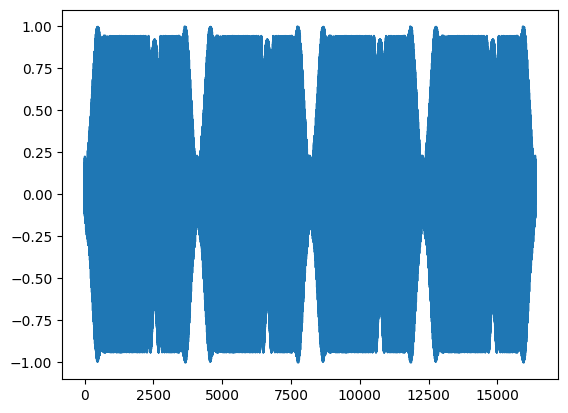

In [70]:
plt.plot(BE_wave)
print(len(BE_wave))

In [8]:
from bandexcitation.File.DataWriter import DataConverter

In [9]:
freqs = DataConverter.BE_frequencies(len(BE_wave), 4e6)
plt.plot(freqs)

NameError: name 'BE_wave' is not defined

In [10]:
inds = DataConverter.extract_freq_range(freqs, (1.31e6-200e3/2, 1.31e6+200e3/2), num_bins)

plt.plot(freqs[inds],'o')

NameError: name 'freqs' is not defined

In [11]:
binned_freq = DataConverter.BE_bin(freqs[inds], num_bins) #num bins

NameError: name 'freqs' is not defined

In [12]:
np.max(binned_freq)

NameError: name 'binned_freq' is not defined

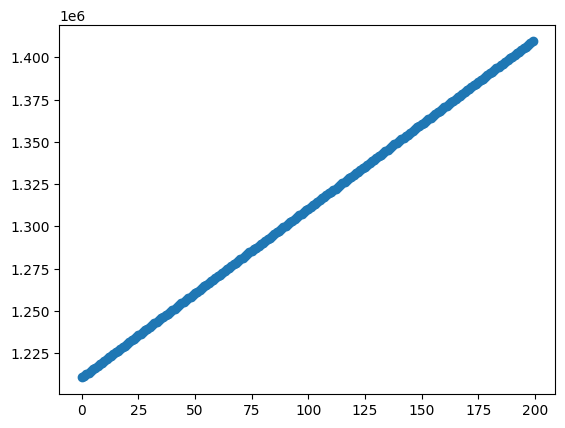

In [76]:
plt.plot(binned_freq, 'o')

In [77]:
BE_FFT = DataConverter.BE_FFT(BE_wave) #num bins

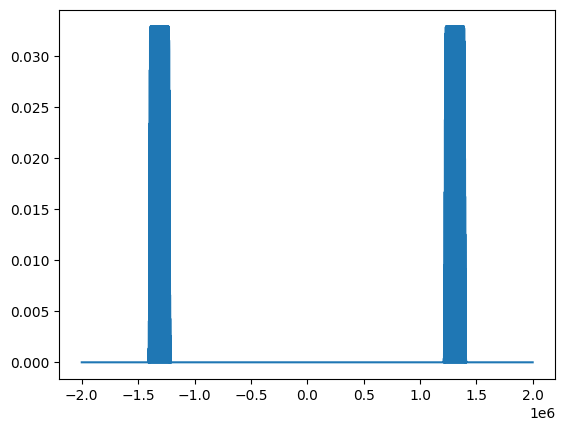

In [78]:
plt.plot(freqs, np.abs(BE_FFT))

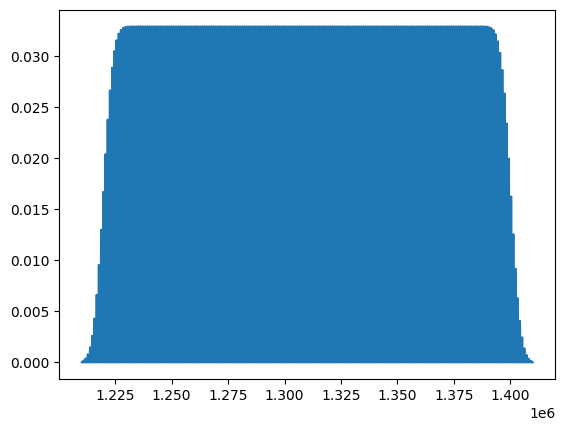

In [132]:
plt.plot(freqs[inds], np.abs(BE_FFT[inds]))

In [80]:
binned_complex = DataConverter.BE_bin(BE_FFT[inds], num_bins)

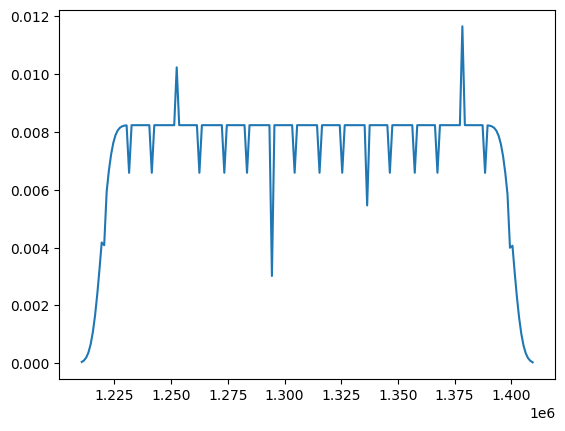

In [82]:
plt.plot(binned_freq, np.abs(binned_complex))

## Try on generated data

Initializing BEparams
0
(1210000.0, 1410000.0)


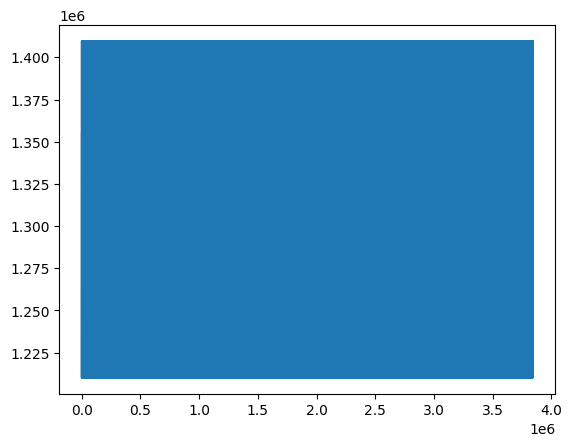

In [2]:
from bandexcitation.Measurement.BEMeasurement import BEMeasurement
from bandexcitation.File.DataWriter import DataConverter

beparms = BEMeasurement(spectroscopic_min_voltage=-4, 
                   spectroscopic_max_voltage=4, 
                   BE_rep=4, 
                   BE_time = 1e-3,
                   AI_sample_rate=4e6, 
                   BE_ppw = 2**15//4,
                   BE_center_freq = 1310000, 
                   BE_bandwidth = 200000, 
                   BE_num_bins = 200,
                   
                  )

data_converter = DataConverter(beparms)

wave = beparms.get_simulated_BE_measurement()

import matplotlib.pyplot as plt

plt.plot(data_converter.get_spectroscopic_freq())

# I think the time should be by the entire chirp, thus we should fix this so that the BE_PPW, and BE_Time is divided by the number of reps

In [48]:
data_converter.update_binning(wave)

(1210000.0, 1410000.0)


(1210000.0, 1410000.0)


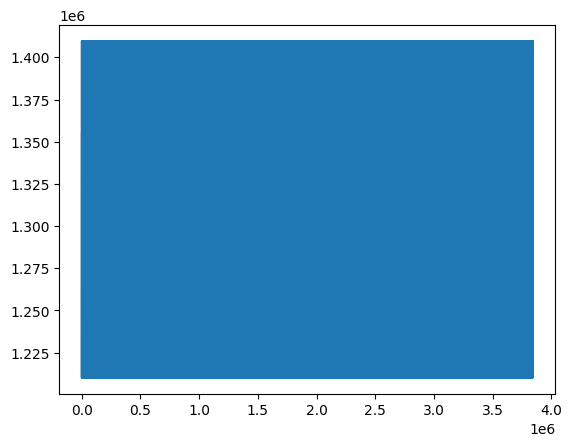

In [49]:
import matplotlib.pyplot as plt

plt.plot(data_converter.get_spectroscopic_freq())

In [5]:
out = beparms.PXI()

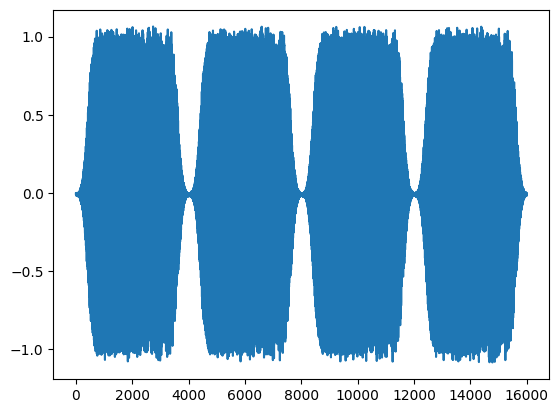

In [6]:
plt.plot(out[0:16000])

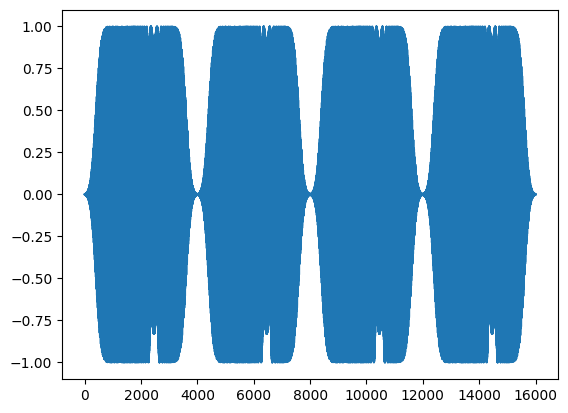

In [7]:
import matplotlib.pyplot as plt
plt.plot(wave)

In [50]:
import numpy as np
BE = data_converter.bin_signal(out[0:16000])

plt.plot(data_converter.binned_freqs, np.abs(BE),'o')

NameError: name 'out' is not defined

In [37]:
import pyUSID as usid

channel = file["/Measurement_000/Channel_000/Raw_Data"]

pd_raw = usid.USIDataset(channel)


print('Desctiption of physical quantity in the Main dataset:')
print(pd_raw.data_descriptor)
print('Position Dimension names and sizes:')
for name, length in zip(pd_raw.pos_dim_labels, pd_raw.pos_dim_sizes):
    print('{} : {}'.format(name, length))
print('Spectroscopic Dimension names and sizes:')
for name, length in zip(pd_raw.spec_dim_labels, pd_raw.spec_dim_sizes):
    print('{} : {}'.format(name, length))
print('Position Dimensions:')
print(pd_raw.pos_dim_descriptors)
print('Spectroscopic Dimensions:')
print(pd_raw.spec_dim_descriptors)

Desctiption of physical quantity in the Main dataset:
Piezoresponse (V)
Position Dimension names and sizes:
Y : 60
X : 60
Spectroscopic Dimension names and sizes:
Frequency : 165
DC_Offset : 96
Field : 2
Cycle : 2
Position Dimensions:
['Y (um)', 'X (um)']
Spectroscopic Dimensions:
['Frequency (Hz)', 'DC_Offset (V)', 'Field ()', 'Cycle ()']


In [7]:
import pyUSID as usid
import sidpy
import numpy as np
import h5py


# all we need are these values to build the file
# Need to flip the order
# then we need to build the atributes in the data writer

x = np.linspace(0, 60, 60)
y = np.linspace(0, 60, 60)
freqs_bin = data_converter.binned_freqs
DC_voltage = beparms.be_spectroscopy.DC_waveform
field = np.array([1,0])
cycle = np.array([0,1])

pos_dims = [usid.Dimension('Cols', 'nm', x),
            usid.Dimension('Rows', 'um', y)]
spec_dims = [usid.Dimension('Frequency', 'Hz', freqs_bin),
             usid.Dimension('DC_Offset', 'V', DC_voltage),
                usid.Dimension('Field', '', field),
             usid.Dimension('Cycle', '', cycle)]




with h5py.File(file_path, mode='w') as h5_file:


c:\Users\M3 Learning\anaconda3\envs\be\lib\site-packages\pyUSID\io\hdf_utils\simple.py:1072: UserWarning: In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying
  warn('In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying')
c:\Users\M3 Learning\anaconda3\envs\be\lib\site-packages\pyUSID\io\hdf_utils\simple.py:1129: UserWarning: pyUSID.io.hdf_utils.simple.write_ind_val_dsets no longer createsregion references for each dimension. Please use pyUSID.io.reg_ref.write_region_references to manually create region references
  warn('pyUSID.io.hdf_utils.simple.write_ind_val_dsets no longer creates'


In [25]:
file_path = 'test4.h5'

with h5py.File(file_path, mode='w') as h5_file:
    h5_meas_group = sidpy.prov_utils.create_indexed_group(h5_file, 'Measurement')
    h5_raw = usid.hdf_utils.write_main_dataset(h5_meas_group,  # parent HDF5 group
                                            (len(x) * len(y), len(freqs_bin)*len(DC_voltage) * len(cycle)*len(field)),  # shape of Main dataset
                                            'Raw_Data',  # Name of main dataset
                                            'Current',  # Physical quantity contained in Main dataset
                                            'nA',  # Units for the physical quantity
                                            pos_dims,  # Position dimensions
                                            spec_dims,  # Spectroscopic dimensions
                                            dtype=np.float32,  # data type / precision
                                            compression='gzip',
                                            main_dset_attrs={'IO_rate': 4E+6, 'Amplifier_Gain': 9})
    sidpy.hdf_utils.print_tree(h5_file)
    for dset in [h5_raw, h5_raw.h5_spec_inds, h5_raw.h5_pos_vals]:
        print('Is {} is a Main dataset?: {}'.format(dset.name, usid.hdf_utils.check_if_main(dset)))

/
├ Measurement_000
  ---------------
  ├ Position_Indices
  ├ Position_Values
  ├ Raw_Data
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
Is /Measurement_000/Raw_Data is a Main dataset?: True
Is /Measurement_000/Spectroscopic_Indices is a Main dataset?: False
Is /Measurement_000/Position_Values is a Main dataset?: False


In [28]:
with h5py.File(file_path, mode='r+') as h5_file:
    pd_raw = h5_file['/Measurement_000/Raw_Data'] #usid.USIDataset(channel)

    pd_raw = usid.USIDataset(pd_raw)

    print('Desctiption of physical quantity in the Main dataset:')
    print(pd_raw.data_descriptor)
    print('Position Dimension names and sizes:')
    for name, length in zip(pd_raw.pos_dim_labels, pd_raw.pos_dim_sizes):
        print('{} : {}'.format(name, length))
    print('Spectroscopic Dimension names and sizes:')
    for name, length in zip(pd_raw.spec_dim_labels, pd_raw.spec_dim_sizes):
        print('{} : {}'.format(name, length))
    print('Position Dimensions:')
    print(pd_raw.pos_dim_descriptors)
    print('Spectroscopic Dimensions:')
    print(pd_raw.spec_dim_descriptors)

Desctiption of physical quantity in the Main dataset:
Current (nA)
Position Dimension names and sizes:
Rows : 60
Cols : 60
Spectroscopic Dimension names and sizes:
Cycle : 2
Field : 2
DC_Offset : 190
Frequency : 200
Position Dimensions:
['Rows (um)', 'Cols (nm)']
Spectroscopic Dimensions:
['Cycle ()', 'Field ()', 'DC_Offset (V)', 'Frequency (Hz)']


In [84]:
h5_raw = usid.hdf_utils.write_main_dataset(h5_meas_group,  # parent HDF5 group
                                           (len(x) * len(y), len(freqs_bin)*len(DC_voltage) * len(cycle)*len(field)),  # shape of Main dataset
                                           'Raw_Data',  # Name of main dataset
                                           'Current',  # Physical quantity contained in Main dataset
                                           'nA',  # Units for the physical quantity
                                           pos_dims,  # Position dimensions
                                           spec_dims,  # Spectroscopic dimensions
                                           dtype=np.float32,  # data type / precision
                                           compression='gzip',
                                           main_dset_attrs={'IO_rate': 4E+6, 'Amplifier_Gain': 9})

KeyError: 'Dataset named: Position_Indices already exists in group: /Measurement_000. Consider passing these datasets using kwargs (if they are correct) instead of providing the pos_dims and spec_dims arguments'

KeyError: 'Unable to open object (component not found)'

<HDF5 group "/Measurement_000" (2 members)>

The data was rebinned to some value (above 165), and then there were 2 cycles with the off and on state 165*4

bins*(off = 1, on and off = 2) @ each voltage step. 

In [9]:
beparms.be_spectroscopy.points_per_cycle

96

In [10]:
DC_offset=beparms.be_spectroscopy.DC_wave

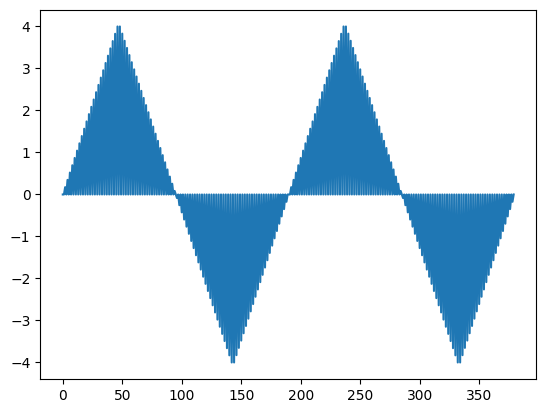

In [11]:
plt.plot(beparms.be_spectroscopy.DC_wave)

In [13]:
beparms.BE_num_bins*multiple*96*2

76800

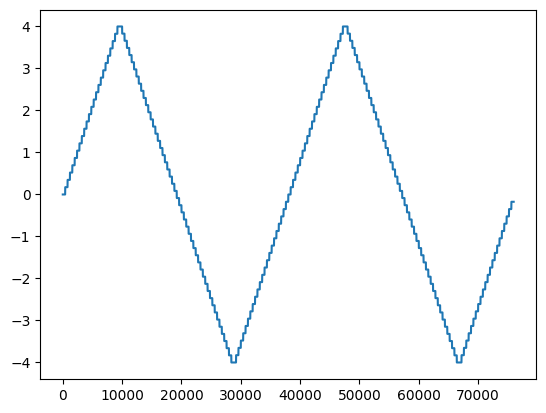

In [12]:
if beparms.spectroscopic_measurement_state == "on and off":
    multiple = 2
else: multiple = 1

plt.plot()

In [30]:
if beparms.spectroscopic_measurement_state == "on and off":
    vec = np.array([1,0])
elif beparms.spectroscopic_measurement_state == "on":
    vec = np.array([1])
elif beparms.spectroscopic_measurement_state == "off":
    vec = np.array([0])

vec_binned = data_converter.tile_and_offset(np.zeros(data_converter.be_measurement.BE_num_bins), vec)
vector_binned = data_converter.tile_and_offset(vec_binned, np.zeros(len(beparms.be_spectroscopy.DC_waveform)))

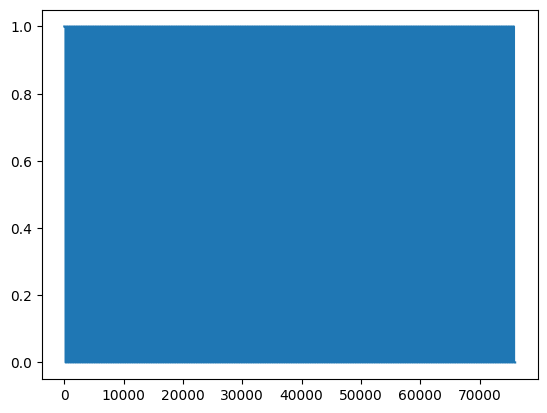

In [33]:
plt.plot(vector_binned)

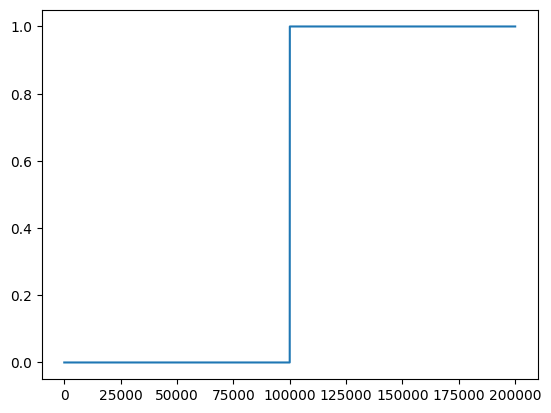

In [3]:
import matplotlib.pyplot as plt
plt.plot(data_converter.cycle(beparms.BE_nums_bins*h))

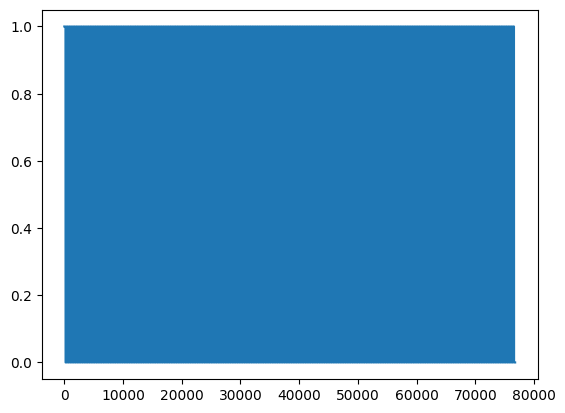

In [8]:
import matplotlib.pyplot as plt
plt.plot(data_converter.feild(beparms.BE_num_bins,beparms.spectroscopic_points*2))

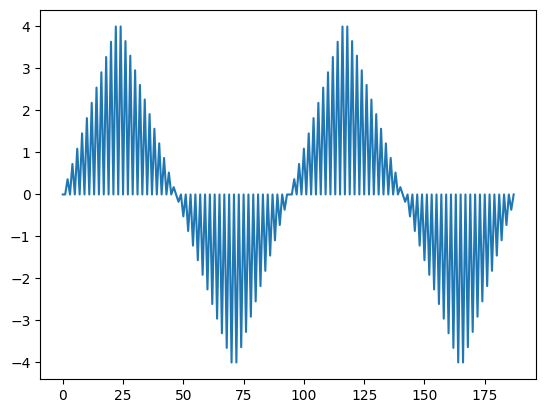

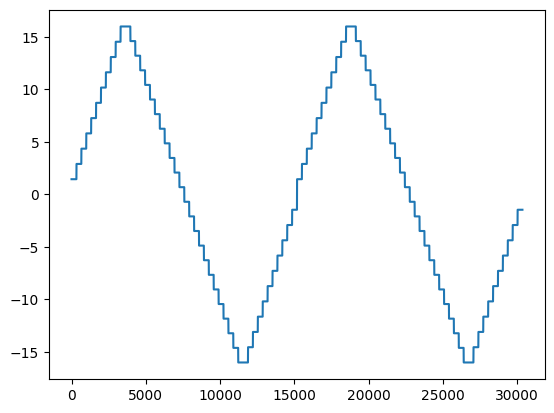

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain


bandwith = 330
DC_offset = []
for i in range(len(DC_waves)-1):
    if DC_waves[i] == 0:
        #DC_offset.extend([DC_waves[i-1]+((DC_waves[i+1]/1)*4)] * bandwith)
        pass
    else:

        DC_offset.extend([DC_waves[i]*4] * bandwith)

plt.plot(DC_waves)

plt.show()

 

plt.plot(DC_offset)

plt.show()

Initializing BEparams
0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt





TypeError: unsupported operand type(s) for //: 'int' and 'NoneType'

In [ ]:
BE = data_converter.BE_FFT(wave)
freq = data_converter.BE_frequencies(len(wave), 1e6)

(-549987.5, 549737.5)

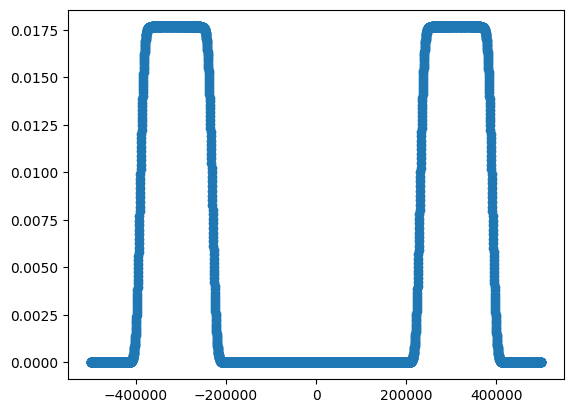

In [ ]:
plt.plot(freq, np.abs(BE),'o')
plt.xlim()

In [ ]:
# from dataclasses import dataclass 

# @dataclass
# class DataConverter:
#     be_measurement: object
    
#     def __post_init__(self):
#         pass
    
#     def get_spectroscopic_dimension(self):
#         # this calls all the subfunctions to get the spectroscopic dimension
#         pass

#     def update_binning(self, signal, **kwargs):

#         N = len(signal)
        
#         # get BE frequencies
#         freqs = self.BE_frequencies(N, self.be_measurement.AI_sample_rate)
        
#         if self.be_measurement.BE_num_bins is not None:
#             # get the masked regions
#             self.inds = self.extract_freq_range(freqs, self.be_measurement.BE_graph_range(multiple=1.05))
#             # Verify if number of bins is too large
#             if self.be_measurement.BE_num_bins > len(self.inds):
#                 raise ValueError("Number of bins is greater than the number of FFT points within the frequency range.")
#         else:
#             self.inds = np.where(freqs>=0)
            
#         freqs_filtered = freqs[self.inds]
        
#         self.binned_freqs = self.BE_bin(freqs_filtered, self.be_measurement.BE_num_bins)
            
    
#     def bin_signal(self, signal, **kwargs):
        
#         if not hasattr(self, 'inds'):
#             self.update_binning(signal, **kwargs)
        
#         # Compute the Normalized FFT
#         FFT_ = self.BE_FFT(signal)

#         # Filter the FFT
#         FFT_filtered = FFT_[self.inds]
        
#         binned_complex = self.BE_bin(FFT_filtered, self.be_measurement.BE_num_bins)

#         return binned_complex
       
#     @staticmethod
#     def BE_bin(signal, num_bins):
        
#         # Perform the binning
#         bin_size = len(signal) // num_bins
        
#         # Reshape and average
#         reshaped_signal = signal[:num_bins * bin_size].reshape(num_bins, -1)
#         avg_signal = np.mean(reshaped_signal, axis=1)
        
#         return avg_signal

#     @staticmethod
#     def BE_frequencies(number_of_points, sampling_frequency):
        
#         freqs = np.fft.fftfreq(number_of_points, 1/sampling_frequency)
#         freqs = np.fft.fftshift(freqs)
        
#         return freqs
    
#     @staticmethod
#     def BE_FFT(signal):
        
#         FFT_ = np.fft.fft(signal) / len(signal)  # FFT and normalization
#         FFT_ = np.fft.fftshift(FFT_) # Shift FFT and keep one side
#         return FFT_
    
    

#     # def BE_freq_bins(self, **kwargs):
#     #     BE_wave = self.be_measurement.get_simulated_BE_measurement()
#     #     freqs = np.fft.fftfreq(len(BE_wave), 1/self.be_measurement.AI_sample_rate)
#     #     self.ind = self.extract_freq_range(freqs, **kwargs)
#     #     self.freqs = freqs[self.ind]

#     @staticmethod
#     def extract_freq_range(freqs, _range):
#         range_ = (_range[0], _range[1])
#         indices = np.where((freqs >= range_[0]) & (freqs <= range_[1]))[0]
#         return indices
        
#     @property
#     def frequency_dimension(self):
#         # this gets the frequency bins from the FFT
#         pass
    
#     @property
#     def DC_offset_dimension(self):
#         pass
    
#     def get_field_dimension(self):
#         pass
    
#     @property
#     def cycle_dimension(self):
#         pass
    
#     @property
#     def binned_freqs(self):
#         return self._binned_freqs
    
#     @binned_freqs.setter
#     def binned_freqs(self, value):
#         self._binned_freqs = value
    

    


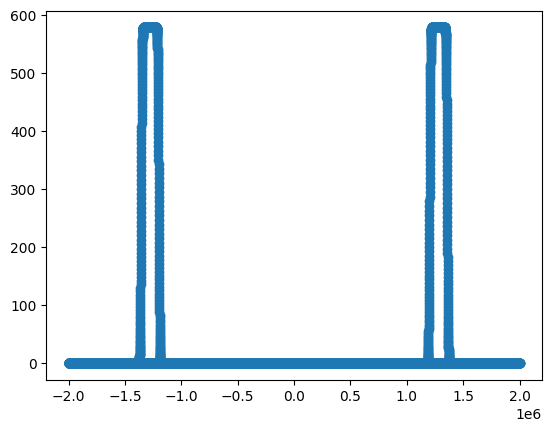

In [ ]:
import numpy as np
fft_vals = np.fft.fft(wave)
fft_shift = np.fft.fftshift(fft_vals)
freqs = np.fft.fftfreq(len(wave),1/4e6)
# Shift the FFT values so that the center frequency is at 0 Hz
freqs = np.fft.fftshift(freqs)
plt.plot(freqs, np.abs(fft_shift),'o')

In [ ]:
channel = h5_

In [ ]:
channel["Spectroscopic_Values"]

NameError: name 'channel' is not defined

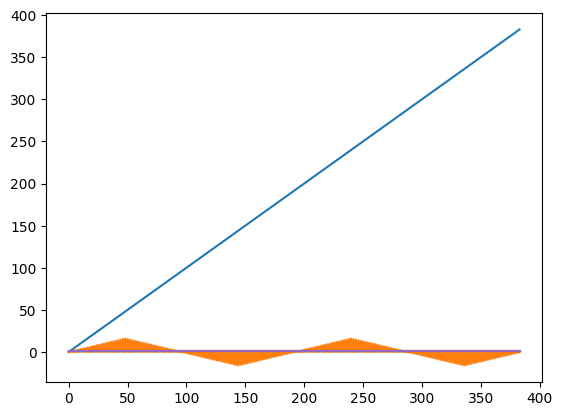

In [ ]:
plt.plot(channel['UDVS'])

In [ ]:
file_path = 'testing.h5'
h5s_file = h5py.File(file_path, mode='w')

In [36]:
# creates the measurement group
h5s_meas_group = sidpy.prov_utils.create_indexed_group(h5s_file, 'Measurement')
h5s_chan_group = sidpy.prov_utils.create_indexed_group(h5s_meas_group, 'Channel')

NameError: name 'sidpy' is not defined

In [ ]:
## TODO need to fix these based on values --- 
sidpy.hdf_utils.write_simple_attrs(h5s_meas_group, {'BE_actual_duration_[s]': 0.004,
                                                'BE_amplitude_[V]': 1,
                                                'BE_auto_smoothing': 'auto smoothing on',
                                                'BE_band_edge_smoothing_[s]' : 4832.1,
                                                'BE_band_edge_trim' : 0.094742,
                                                'BE_band_width_[Hz]' : 200000,
                                                'BE_bins_per_band' : 0,
                                                'BE_center_frequency_[Hz]' : 1310000,
                                                'BE_desired_duration_[s]' : 0.004,
                                                'BE_phase_content' : 'chirp-sinc hybrid',
                                                'BE_phase_variation' : 1,
                                                'BE_points_per_BE_wave' : 0,
                                                'BE_repeats' : 4,
                                                'FORC_V_high1_[V]' : 1,
                                                'FORC_V_high2_[V]' : 10,
                                                'FORC_V_low1_[V]' : -1,
                                                'FORC_V_low2_[V] ': -10,
                                                'FORC_num_of_FORC_cycles' : 1,
                                                'FORC_num_of_FORC_repeats' : 1,
                                                'File_MDAQ_version' : 'MDAQ_VS_090915_01', 
                                                'File_date_and_time' : '18-Sep-2015 18:32:14', 
                                                'File_file_name' : 'SP128_NSO',
                                                'File_file_path' : 'testing',
                                                'File_file_suffix' : 99,
                                                'IO_AO_amplifier' : 10,
                                                'IO_AO_range_[V]' : '+/- 10',
                                                'IO_Analog_Input_1' : '+/- .1V, FFT', 
                                                'IO_Analog_Input_2' : 'off', 
                                                'IO_Analog_Input_3' : 'off',
                                                'IO_Analog_Input_4' : 'off',
                                                'IO_DAQ_platform' : 'NI 6115',
                                                'IO_rate_[Hz]' : 4000000,
                                                'VS_amplitude_[V]' : 16, 
                                                'VS_cycle_fraction' : 'full',
                                                'VS_cycle_phase_shift' : 0,
                                                'VS_measure_in_field_loops' : 'in and out-of-field',
                                                'VS_mode' : 'DC modulation mode',
                                                'VS_number_of_cycles' : 2,
                                                'VS_offset_[V]' : 0,
                                                'VS_read_voltage_[V]' : 0,
                                                'VS_set_pulse_amplitude[V]' : 0,
                                                'VS_set_pulse_duration[s]' : 0.002,
                                                'VS_step_edge_smoothing_[s]' : 0.001,
                                                'VS_steps_per_full_cycle' : 96,
                                                'data_type' : 'BEPSData', 
                                                'grid_/single' : 'grid',
                                                'grid_contact_set_point_[V]' : 1,
                                                'grid_current_col' : 1,
                                                'grid_current_row' : 1,
                                                'grid_cycle_time_[s]' : 10,
                                                'grid_measuring' : 0,
                                                'grid_moving ': 0,
                                                'grid_num_cols' : 60,
                                                'grid_num_rows' : 60,
                                                'grid_settle_time_[s]' : 0.15,
                                                'grid_time_remaining_[h;m;s]' : 10,
                                                'grid_total_time_[h;m;s]' : 10,
                                                'grid_transit_set_point_[V]' : 0.1,
                                                'grid_transit_time_[s]' : 0.15,
                                                'num_bins' : 165,
                                                'num_pix' : 3600,
                                                'num_udvs_steps' : 384})